In [2]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scib
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# Logistic regression Classifiers for RxRx19b, HUVEC

For more information on the dataset please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

* [I. Read in processed data](#read)
* [II. Label key: disease condition](#dc)
    * [A. Logistic regression before integration](#dc_sub1)
    * [B. Logistic regression after integration with harmony](#dc_sub2)
    * [C. Logistic regression after integration with scanorama](#dc_sub3)
    * [D. Logistic regression after integration with scVI](#dc_sub4)
    * [E. Logistic regression after integration with scANVI](#dc_sub5)
    * [F. Logistic regression after integration with scGEN](#dc_sub6)
* [III. Label key: treatment](#treat)
    * [A. Logistic regression before integration](#treat_sub1)
    * [B. Logistic regression after integration with harmony](#treat_sub2)
    * [C. Logistic regression after integration with scanorama](#treat_sub3)
    * [D. Logistic regression after integration with scVI](#treat_sub4)
    * [E. Logistic regression after integration with scANVI](#treat_sub5)
    * [F. Logistic regression after integration with scGen](#treat_sub6)
* [IV. Investigate biology for misclassified instances](#bio)
    * [A. DrugBank search for misclassified instances](#bio_sub1) 
    * [B. DrugBank search for misclassified instances from logistic regression harmony](#bio_sub2) 
    * [C. DrugBank search for misclassified instances from logistic regression scanorama](#bio_sub3) 
    * [D. DrugBank search for misclassified instances from logistic regression scVI](#bio_sub4) 
    * [E. DrugBank search for misclassified instances from logistic regression scANVI](#bio_sub5) 
    * [F. DrugBank search for misclassified instances from logistic regression scGen](#bio_sub6) 

## I. Read in processed data  <a class="anchor" id="read"></a>

Load in both anndata objects: processed adata (before harmony integration) and harmony (after integration).

In [3]:
# Adata before integration
adata = sc.read("./rxrx19b_adata.h5ad")
adata.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0,0.076258
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0,0.132280
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,0.092923
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,0,0.074591
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,0,0.060353
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,-0.041384
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,0.124158
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,0.160160


In [4]:
# Harmony after integration
harmony = sc.read("./rxrx19b_harmony.h5ad")
harmony.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,silhouette_temp,cluster
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0.036751,0
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0.026141,0
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.010373,0
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,-0.029200,0
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,-0.024376,0
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,-0.050457,3
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0.120337,0
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0.167888,0


In [5]:
# Scanorama integration
scanorama = sc.read("./rxrx19b_scanorama.h5ad")
scanorama.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_1_AA02_1,HUVEC-1_1_AA02,HUVEC,HUVEC-1,1,AA02,1,storm-severe,Ravoxertinib,1.000,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...,0,0.092706
HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,storm-severe,Diphenylpyraline,0.250,"CN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1 |c:12,14...",0,0.158894
HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,storm-severe,Indirubin,1.000,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...,0,0.101708
HUVEC-1_1_AA05_1,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,1,storm-severe,YO-01027,1.000,C[C@H](NC(=O)CC1=CC(F)=CC(F)=C1)C(=O)N[C@H]1C2...,0,0.123514
HUVEC-1_1_AA07_1,HUVEC-1_1_AA07,HUVEC,HUVEC-1,1,AA07,1,storm-severe,taurine,1.000,NCCS(O)(=O)=O,0,0.107874
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,-0.099862
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,0.155186
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,0.196267


In [6]:
# scVI integration
scVI = sc.read("./rxrx19b_scVI.h5ad")
scVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0,-0.543727
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0,-0.621687
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,-0.628575
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,0,-0.529617
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,0,-0.535285
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,-0.196521
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,-0.512787
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,-0.510937


In [7]:
# scANVI integration
scANVI = sc.read("./rxrx19b_scANVI.h5ad")
scANVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0,0.786475
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0,0.754290
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,0.814158
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,0,0.816677
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,0,0.732051
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,0.048619
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,0.802998
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,0.776060


In [8]:
# scGen integration
scGen = sc.read("./rxrx19b_scGen.h5ad")
scGen.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,_scvi_batch,_scvi_labels,concat_batch,cluster,silhouette_temp
site_id,,,,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,9,2,0,1,-0.098082
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,9,2,0,0,0.054734
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,9,2,0,0,-0.028665
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,9,2,0,0,-0.028265
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,9,2,0,0,-0.042708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,8,1,0,1,-0.057290
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,8,2,0,0,0.103738
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",8,2,0,0,0.110647


In [9]:
# Treatments before integration
treatment = sc.read("./rxrx19b_top_50_treatments.h5ad")
treatment.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,19,-0.064533
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,15,-0.040772
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,-0.101457
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,15,0.046645
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,-0.121994
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,19,-0.030097
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,7,-0.062839
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,19,-0.006083


In [10]:
# Treatments Harmony after integration
treatment_harmony = sc.read("./rxrx19b_top_50_treatments_harmony.h5ad")
treatment_harmony.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,silhouette_temp,cluster
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.079270,0
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.112874,11
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.193622,2
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.092716,11
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.197519,2
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.077464,15
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.104707,1
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.059804,15


In [11]:
# Treatments after scanorama integration
treatment_scanorama = sc.read("./rxrx19b_top_50_treatments_scanorama.h5ad")
treatment_scanorama.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,4,-0.035203
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,10,-0.135421
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,17,-0.112351
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,10,0.013212
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.133789
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,8,-0.084234
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,-0.025475
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.083531


In [12]:
# Treatments after scVI integration
treatment_scVI = sc.read("./rxrx19b_top_50_treatments_scVI.h5ad")
treatment_scVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.516933
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,-0.110241
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,1,-0.503312
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,-0.249883
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.537056
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.501894
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,-0.528379
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.538724


In [13]:
# Treatments after scanVI integration
treatment_scANVI = sc.read("./rxrx19b_top_50_treatments_scANVI.h5ad")
treatment_scANVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.280787
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,0.021866
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,1,-0.283447
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,0.008462
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.442699
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.021719
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,-0.237868
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.120097


In [14]:
# Treatments after scGen integration
treatment_scGen = sc.read("./rxrx19b_top_50_treatments_scGen.h5ad")
treatment_scGen.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,_scvi_batch,_scvi_labels,cluster,silhouette_temp
site_id,,,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.103188
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.080010
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.113245
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.218554
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.105714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,27,23,0.177709
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,27,3,-0.036196
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,27,23,0.118412


## II. Label key: disease condition  <a class="anchor" id="dc"></a>

<b>Goal:<b>
    
1. We want a classifier which can correctly classify instances into the categories "healthy" or "storm-severe" (different treatments in III.). We discard the "blank" case as this group clusters within the "healthy" cluster and is only included in plate 53. 

2. We want to check if after integration the classifiers performance improves or not.

<b> Why logistic regression? <b>

*  assumes a linear relationship between the features and the log-odds, but it can capture non-linear patterns by using feature transformations.
*  can handle both binary and multi-class classification problems using techniques like one-vs-rest or multinomial logistic regression.
* generally less computationally intensive compared to SVM.

However, it my struggle with datasets that have complex non-linear decision boundaries.

### A. Logistic regression before integration  <a class="anchor" id="dc_sub1"></a>

<b> Step 1: <b>
    
Split adata into training and test sets and remove the "blank" condition before training.

In [4]:
# Make new adata_object (before integration)
adata_no_blank = adata.copy()

# Filter cells with "blank" disease condition
adata_no_blank = adata_no_blank[adata_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
adata_no_blank.obs["n_cells"] = adata_no_blank.X.sum(axis=1)

# Update the observation index
adata_no_blank.obs.index = range(adata_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
adata_no_blank.obs["disease_condition"] = adata_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
adata_no_blank = adata_no_blank[~adata_no_blank.obs["disease_condition"].isna()]

In [5]:
# Perform PCA on `adata` without batch correction or integration
sc.tl.pca(adata_no_blank, n_comps=50)  # Choose the desired number of components

# Split adata_no_blank into train and test
X_adata_no_blank = adata_no_blank.obsm["X_pca"]
y_adata_no_blank = adata_no_blank.obs['disease_condition']

X_train_adata, X_test_adata, y_train_adata, y_test_adata = train_test_split(X_adata_no_blank, y_adata_no_blank, test_size=0.2, random_state=42)

In [6]:
adata_no_blank.obsm["X_pca"]

array([[ 1.3651953e+00, -1.2343433e+00,  1.1859227e+00, ...,
        -2.3331618e-01, -1.8383896e-01, -3.3549076e-01],
       [-1.0056266e+00,  5.0491758e-02, -1.1128535e+00, ...,
         4.2527881e-01,  1.3812271e-01,  8.5469864e-02],
       [-4.8382667e-01, -1.8016112e+00, -2.9532328e-01, ...,
        -5.4519787e-02, -1.6023353e-01, -8.3027622e-03],
       ...,
       [-8.7735802e-02, -1.0194504e+00,  6.5616220e-01, ...,
         1.6858843e-01, -3.4408242e-01, -2.5574991e-01],
       [ 1.4133677e+00, -1.9894869e+00, -2.3276141e+00, ...,
         5.9777573e-03, -5.2248532e-01,  3.3537263e-01],
       [ 2.2478988e+00, -6.6597924e+00, -3.4944057e-01, ...,
         1.0794930e-01,  5.9323762e-02, -1.3666278e-01]], dtype=float32)

<b> Step 2: <b>
    
Train the logisitc regression classifier.

In [8]:
# Training
logreg_classifier_adata = LogisticRegression(solver='liblinear')
logreg_classifier_adata.fit(X_train_adata, y_train_adata)

LogisticRegression(solver='liblinear')

<b> Step 3: <b>
    
Use the trained logisitic regression classifier to make predictions on the test set.

In [9]:
# Testing for adata_no_blank
y_pred_adata = logreg_classifier_adata.predict(X_test_adata)

# Predict probabilities for test data
probabilities = logreg_classifier_adata.predict_proba(X_test_adata)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)

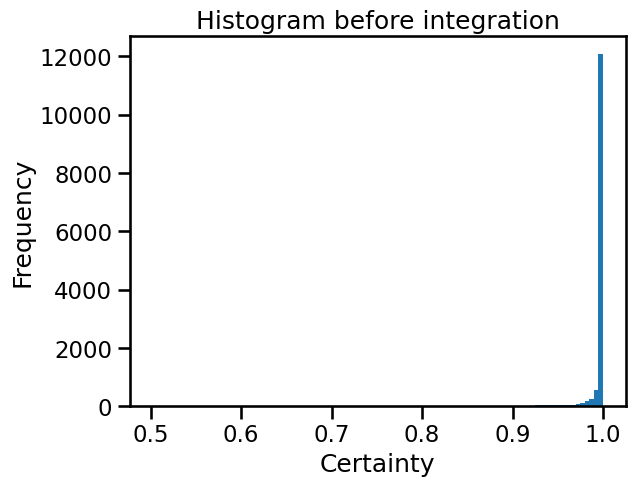

In [10]:
# Plot histogram
plt.hist(uncertainty_measures, bins=100) 
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram before integration')
plt.show()

We now only have two classes (binary classification!), "healthy" and "storm-severe", the uncertainty measures therefore represent the probability estimates for each prediction. 

The majority of the predictions have a certainty of (almost) 1, indicating that the classifier is very confident in its predictions for those samples. 

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [11]:
# Evaluating for adata_no_blank
accuracy_logreg_adata = accuracy_score(y_test_adata, y_pred_adata)
confusion_logreg_adata = confusion_matrix(y_test_adata, y_pred_adata)
classification_rep_logreg_adata = classification_report(y_test_adata, y_pred_adata)

# Calculate the true positives for each class
true_positives = np.diag(confusion_logreg_adata)

# Calculate the total instances for each class
total_instances = np.sum(confusion_logreg_adata, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_logreg_adata)
print("Confusion Matrix:")
print(confusion_logreg_adata)
print("Classification Report:")
print(classification_rep_logreg_adata)

Balanced Accuracy: 0.9226668101853185
Accuracy: 0.9881631488876212
Confusion Matrix:
[[  454    79]
 [   87 13404]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.84      0.85      0.85       533
storm-severe       0.99      0.99      0.99     13491

    accuracy                           0.99     14024
   macro avg       0.92      0.92      0.92     14024
weighted avg       0.99      0.99      0.99     14024



<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [12]:
# Perform 5-fold cross-validation on adata_no_blank
logreg_classifier_adata = LogisticRegression(solver='liblinear')
cv_scores_adata = cross_val_score(logreg_classifier_adata, X_train_adata, y_train_adata, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_adata)
print("Mean CV Score:", np.mean(cv_scores_adata))

Cross-Validation Scores: [0.98832442 0.98743203 0.98974953 0.98832338 0.9870755 ]
Mean CV Score: 0.9881809729134383


### B. Logistic regression after integration with harmony  <a class="anchor" id="dc_sub2"></a>

<b> Step 1: <b>
    
Split adata and harmony into training and test sets and remove the "blank" condition before training.

In [13]:
# Make new harmony_object (after integration) and discarding the "blank" condition
harmony_no_blank = harmony.copy()

# Filter cells with "blank" disease condition
harmony_no_blank = harmony_no_blank[harmony_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
harmony_no_blank.obs["n_cells"] = harmony_no_blank.X.sum(axis=1)

# Update the observation index
harmony_no_blank.obs.index = range(harmony_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
harmony_no_blank.obs["disease_condition"] = harmony_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
harmony_no_blank = harmony_no_blank[~harmony_no_blank.obs["disease_condition"].isna()]

In [14]:
# Split harmony_no_blank into train and test
X_harmony_no_blank = harmony_no_blank.obsm['X_emb']
y_harmony_no_blank = harmony_no_blank.obs['disease_condition']

X_train_harmony, X_test_harmony, y_train_harmony, y_test_harmony = train_test_split(X_harmony_no_blank, y_harmony_no_blank, test_size=0.2, random_state=42)

In [15]:
harmony_no_blank.obsm['X_emb']

ArrayView([[ 2.2394414 , -1.7375597 ,  2.7960627 , ..., -0.37198633,
            -0.1691206 , -0.38475117],
           [ 1.9186702 , -0.9331736 ,  0.5725336 , ...,  0.33663914,
             0.2135294 , -0.05475631],
           [ 2.4493425 , -2.7479894 ,  1.3818922 , ..., -0.14319813,
            -0.08162183, -0.14025837],
           ...,
           [-1.2527202 ,  0.44256347,  0.68235373, ...,  0.1390561 ,
            -0.32132152, -0.29450902],
           [ 1.0184435 , -0.5603703 , -2.6472228 , ..., -0.14857054,
            -0.30067638,  0.3474751 ],
           [ 0.7579213 , -4.075646  ,  0.08878634, ...,  0.05327755,
             0.18642084, -0.0782557 ]], dtype=float32)

<b> Step 2: <b>
    
Train the logistic regression classifier.

In [16]:
# Training
logreg_classifier_harmony = LogisticRegression(C=1.0, solver='liblinear')
logreg_classifier_harmony.fit(X_train_harmony, y_train_harmony)

LogisticRegression(solver='liblinear')

<b> Step 3: <b>
    
Use the trained logistic regression classifier to make predictions on the test set.

In [17]:
# Testing for harmony_no_blank
y_pred_harmony = logreg_classifier_harmony.predict(X_test_harmony)

# Predict probabilities for test data
probabilities = logreg_classifier_harmony.predict_proba(X_test_harmony)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)

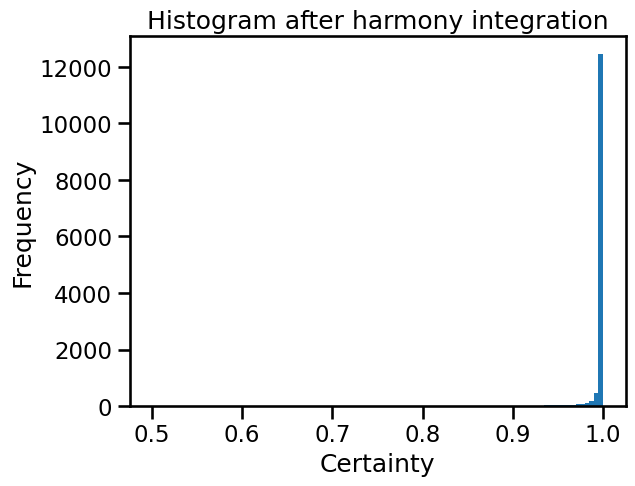

In [18]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after harmony integration')
plt.show()

We again see that the classifier has a very high certainty in general but uncertainty does increase a little bit after integration with harmony compared to the unintegrated uncertainty.

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [19]:
# Evaluating for harmony_no_blank
accuracy_harmony = accuracy_score(y_test_harmony, y_pred_harmony)
confusion_harmony = confusion_matrix(y_test_harmony, y_pred_harmony)
classification_rep_harmony = classification_report(y_test_harmony, y_pred_harmony)

# Calculate the true positives for each class
true_positives = np.diag(confusion_harmony)

# Calculate the total instances for each class
total_instances = np.sum(confusion_harmony, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_harmony)
print("Confusion Matrix:")
print(confusion_harmony)
print("Classification Report:")
print(classification_rep_harmony)

Balanced Accuracy: 0.9398117958703065
Accuracy: 0.9899458071876782
Confusion Matrix:
[[  472    61]
 [   80 13411]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.86      0.89      0.87       533
storm-severe       1.00      0.99      0.99     13491

    accuracy                           0.99     14024
   macro avg       0.93      0.94      0.93     14024
weighted avg       0.99      0.99      0.99     14024



<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [21]:
# Perform 5-fold cross-validation on harmony_no_blank
logistic_classifier = LogisticRegression()

cv_scores_harmony = cross_val_score(logistic_classifier, X_train_harmony, y_train_harmony, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_harmony)
print("Mean CV Score:", np.mean(cv_scores_harmony))

Cross-Validation Scores: [0.99019608 0.99037347 0.99171049 0.98983867 0.98885819]
Mean CV Score: 0.9901953793372238


We can again see that the resulting values are almost identical before and after integration with harmony. The slight difference in the scores could be due to the random variability introduced by the different splits or due to some loss of biological conservation after integration with harmony.

### C. Logistic regression after integration with scanorama  <a class="anchor" id="dc_sub3"></a>

<b> Step 1: <b>
    
Split adata and scanorama into training and test sets and remove the "blank" condition before training.

In [14]:
# Make new harmony_object (after integration) and discarding the "blank" condition
scanorama_no_blank = scanorama.copy()

# Filter cells with "blank" disease condition
scanorama_no_blank = scanorama_no_blank[scanorama_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scanorama_no_blank.obs["n_cells"] = scanorama_no_blank.X.sum(axis=1)

# Update the observation index
scanorama_no_blank.obs.index = range(scanorama_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scanorama_no_blank.obs["disease_condition"] = scanorama_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scanorama_no_blank = scanorama_no_blank[~scanorama_no_blank.obs["disease_condition"].isna()]

In [15]:
# Split harmony_no_blank into train and test
X_scanorama_no_blank = scanorama_no_blank.obsm['X_pca']
y_scanorama_no_blank = scanorama_no_blank.obs['disease_condition']

X_train_scanorama, X_test_scanorama, y_train_scanorama, y_test_scanorama = train_test_split(X_scanorama_no_blank, y_scanorama_no_blank, test_size=0.2, random_state=42)

In [16]:
scanorama_no_blank.obsm['X_pca']

ArrayView([[ 1.2353509e-01, -7.7390738e-02, -1.4122464e-01, ...,
            -4.0428014e-04,  5.4067313e-03,  1.8780761e-03],
           [ 1.1586933e-02, -1.0235124e-01, -2.8946104e-02, ...,
             1.4191536e-03,  6.7304946e-03, -2.7869262e-03],
           [ 4.2632390e-02, -2.1727178e-02,  4.9627670e-03, ...,
            -1.4822840e-04, -6.9791760e-04, -7.2839349e-03],
           ...,
           [ 1.3428365e-02, -8.1897050e-02, -8.0173306e-02, ...,
             1.8805164e-03, -1.1099721e-03,  2.9408853e-03],
           [ 2.0023329e-02, -4.5216024e-02,  1.7057396e-02, ...,
             7.4118224e-04, -5.8279424e-03, -1.3286283e-02],
           [ 8.3542310e-02, -2.6518008e-01,  1.6952690e-01, ...,
             5.8251382e-03, -5.0265361e-03,  8.1523033e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the logistic regression classifier.

In [17]:
# Training
logistic_classifier_scanorama = LogisticRegression()
logistic_classifier_scanorama.fit(X_train_scanorama, y_train_scanorama)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained classifier to make predictions on the test set.

In [18]:
# Testing for scanorama_no_blank
y_pred_scanorama = logistic_classifier_scanorama.predict(X_test_scanorama)

# Predict probabilities for test data
probabilities = logistic_classifier_scanorama.predict_proba(X_test_scanorama)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)

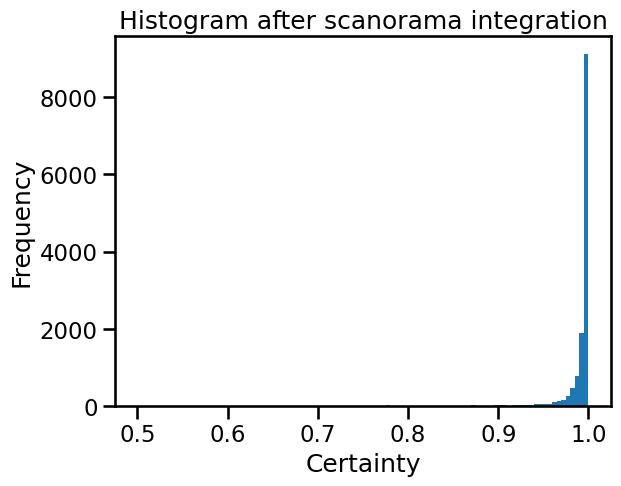

In [19]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scanorama integration')
plt.show()

We see more range in certainty values for scanorama.

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [37]:
# Evaluating for scanorama_no_blank
accuracy_scanorama = accuracy_score(y_test_scanorama, y_pred_scanorama)
confusion_scanorama = confusion_matrix(y_test_scanorama, y_pred_scanorama)
classification_rep_scanorama = classification_report(y_test_scanorama, y_pred_scanorama)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scanorama)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scanorama, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scanorama)
print("Confusion Matrix:")
print(confusion_scanorama)
print("Classification Report:")
print(classification_rep_scanorama)

Balanced Accuracy: 0.8945171393057947
Accuracy: 0.9859526525955505
Confusion Matrix:
[[  450   116]
 [   81 13377]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.85      0.80      0.82       566
storm-severe       0.99      0.99      0.99     13458

    accuracy                           0.99     14024
   macro avg       0.92      0.89      0.91     14024
weighted avg       0.99      0.99      0.99     14024



<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [38]:
# Perform 5-fold cross-validation on scanorama_no_blank
logreg_classifier = LogisticRegression()
cv_scores_scanorama = cross_val_score(logreg_classifier, X_train_scanorama, y_train_scanorama, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scanorama)
print("Mean CV Score:", np.mean(cv_scores_scanorama))

Cross-Validation Scores: [0.98493761 0.98413406 0.98457973 0.98422319 0.98404492]
Mean CV Score: 0.984383903420779


### D. Logistic regression after integration with scVI  <a class="anchor" id="dc_sub4"></a>

<b> Step 1: <b>
    
Split into training and test sets and remove the "blank" condition before training.

In [20]:
# Make new scVI_object (after integration) and discarding the "blank" condition
scVI_no_blank = scVI.copy()

# Filter cells with "blank" disease condition
scVI_no_blank = scVI_no_blank[scVI_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scVI_no_blank.obs["n_cells"] = scVI_no_blank.X.sum(axis=1)

# Update the observation index
scVI_no_blank.obs.index = range(scVI_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scVI_no_blank.obs["disease_condition"] = scVI_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scVI_no_blank = scVI_no_blank[~scVI_no_blank.obs["disease_condition"].isna()]

In [21]:
# Split harmony_no_blank into train and test
X_scVI_no_blank = scVI_no_blank.obsm['X_pca']
y_scVI_no_blank = scVI_no_blank.obs['disease_condition']

X_train_scVI, X_test_scVI, y_train_scVI, y_test_scVI = train_test_split(X_scVI_no_blank, y_scVI_no_blank, test_size=0.2, random_state=42)

In [22]:
scVI_no_blank.obsm['X_pca']

ArrayView([[ 1.52219772e-01, -1.10791340e-01,  1.48034543e-01, ...,
            -5.75463194e-03,  9.31165088e-03, -1.52409645e-02],
           [-1.10116303e-01, -3.66436550e-03, -1.18934117e-01, ...,
             4.35873959e-03,  1.19227776e-02, -1.37304766e-02],
           [-4.42312956e-02, -1.94126233e-01,  3.56000848e-02, ...,
            -1.40653308e-02,  1.39386114e-02, -1.22656906e-02],
           ...,
           [ 1.45090185e-02, -9.42047164e-02,  1.74487650e-01, ...,
             9.74718761e-03,  2.77364370e-03,  1.55082978e-02],
           [ 1.27000481e-01, -2.09646255e-01, -1.87120125e-01, ...,
            -1.28766929e-04, -1.38223004e-02,  2.09101588e-02],
           [ 2.30612487e-01, -6.86844409e-01, -3.73101197e-02, ...,
             1.70994718e-02,  6.86851563e-04,  4.19308059e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the classifier.

In [23]:
# Training
svm_classifier_scVI = LogisticRegression()
svm_classifier_scVI.fit(X_train_scVI, y_train_scVI)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained classifier to make predictions on the test set.

In [24]:
# Testing for harmony_no_blank
y_pred_scVI = svm_classifier_scVI.predict(X_test_scVI)

# Predict probabilities for test data
probabilities = svm_classifier_scVI.predict_proba(X_test_scVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.99996788, 0.99949155, 0.99965337, ..., 0.99997097, 0.99981591,
       0.99750631])

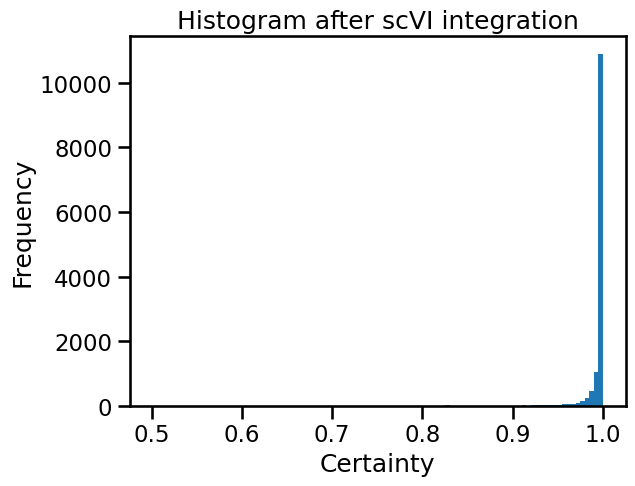

In [25]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scVI integration')
plt.show()

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [26]:
# Evaluating for scVI_no_blank
accuracy_scVI = accuracy_score(y_test_scVI, y_pred_scVI)
confusion_scVI = confusion_matrix(y_test_scVI, y_pred_scVI)
classification_rep_scVI = classification_report(y_test_scVI, y_pred_scVI)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scVI)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scVI, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scVI)
print("Confusion Matrix:")
print(confusion_scVI)
print("Classification Report:")
print(classification_rep_scVI)

Balanced Accuracy: 0.9225926866955846
Accuracy: 0.9880205362236166
Confusion Matrix:
[[  454    79]
 [   89 13402]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.84      0.85      0.84       533
storm-severe       0.99      0.99      0.99     13491

    accuracy                           0.99     14024
   macro avg       0.92      0.92      0.92     14024
weighted avg       0.99      0.99      0.99     14024



<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [48]:
# Perform 5-fold cross-validation on scVI_no_blank
logistic_classifier = LogisticRegression(solver='liblinear')
cv_scores_scVI = cross_val_score(logistic_classifier, X_train_scVI, y_train_scVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scVI)
print("Mean CV Score:", np.mean(cv_scores_scVI))

Cross-Validation Scores: [0.98743316 0.98609502 0.98814511 0.9873429  0.98680809]
Mean CV Score: 0.9871648554567237


### E. Logisitc regression after integration with scANVI  <a class="anchor" id="dc_sub5"></a>

<b> Step 1: <b>
    
Split into training and test sets and remove the "blank" condition before training.

In [27]:
# Make new scVI_object (after integration) and discarding the "blank" condition
scANVI_no_blank = scANVI.copy()

# Filter cells with "blank" disease condition
scANVI_no_blank = scANVI_no_blank[scANVI_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scANVI_no_blank.obs["n_cells"] = scANVI_no_blank.X.sum(axis=1)

# Update the observation index
scANVI_no_blank.obs.index = range(scANVI_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scANVI_no_blank.obs["disease_condition"] = scANVI_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scANVI_no_blank = scANVI_no_blank[~scANVI_no_blank.obs["disease_condition"].isna()]

In [28]:
# Split scANVI_no_blank into train and test
X_scANVI_no_blank = scANVI_no_blank.obsm['X_pca']
y_scANVI_no_blank = scANVI_no_blank.obs['disease_condition']

X_train_scANVI, X_test_scANVI, y_train_scANVI, y_test_scANVI = train_test_split(X_scANVI_no_blank, y_scANVI_no_blank, test_size=0.2, random_state=42)

In [29]:
scANVI_no_blank.obsm['X_pca']

ArrayView([[ 1.52219772e-01, -1.10791340e-01,  1.48034543e-01, ...,
            -5.75463194e-03,  9.31165088e-03, -1.52409645e-02],
           [-1.10116303e-01, -3.66436550e-03, -1.18934117e-01, ...,
             4.35873959e-03,  1.19227776e-02, -1.37304766e-02],
           [-4.42312956e-02, -1.94126233e-01,  3.56000848e-02, ...,
            -1.40653308e-02,  1.39386114e-02, -1.22656906e-02],
           ...,
           [ 1.45090185e-02, -9.42047164e-02,  1.74487650e-01, ...,
             9.74718761e-03,  2.77364370e-03,  1.55082978e-02],
           [ 1.27000481e-01, -2.09646255e-01, -1.87120125e-01, ...,
            -1.28766929e-04, -1.38223004e-02,  2.09101588e-02],
           [ 2.30612487e-01, -6.86844409e-01, -3.73101197e-02, ...,
             1.70994718e-02,  6.86851563e-04,  4.19308059e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the classifier.

In [30]:
# Training
svm_classifier_scANVI = LogisticRegression()
svm_classifier_scANVI.fit(X_train_scANVI, y_train_scANVI)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained classifier to make predictions on the test set.

In [31]:
# Testing for harmony_no_blank
y_pred_scANVI = svm_classifier_scANVI.predict(X_test_scANVI)

# Predict probabilities for test data
probabilities = svm_classifier_scANVI.predict_proba(X_test_scANVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.99996788, 0.99949155, 0.99965337, ..., 0.99997097, 0.99981591,
       0.99750631])

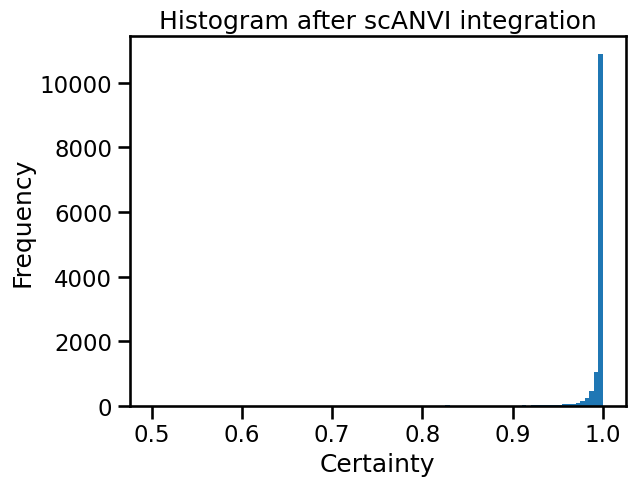

In [32]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scANVI integration')
plt.show()

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [33]:
# Evaluating for scANVI_no_blank
accuracy_scANVI = accuracy_score(y_test_scANVI, y_pred_scANVI)
confusion_scANVI = confusion_matrix(y_test_scANVI, y_pred_scANVI)
classification_rep_scANVI = classification_report(y_test_scANVI, y_pred_scANVI)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scANVI)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scANVI, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scANVI)
print("Confusion Matrix:")
print(confusion_scANVI)
print("Classification Report:")
print(classification_rep_scANVI)

Balanced Accuracy: 0.9225926866955846
Accuracy: 0.9880205362236166
Confusion Matrix:
[[  454    79]
 [   89 13402]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.84      0.85      0.84       533
storm-severe       0.99      0.99      0.99     13491

    accuracy                           0.99     14024
   macro avg       0.92      0.92      0.92     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. The accuracy increases after integration slightly.
    
This may be due to the fact that we already know that scvi scales well for complex, high-dimensional data, better than harmony for instance.

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [34]:
# Perform 5-fold cross-validation on scANVI_no_blank
logistic_classifier = LogisticRegression(solver='liblinear')
cv_scores_scANVI = cross_val_score(logistic_classifier, X_train_scANVI, y_train_scANVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scANVI)
print("Mean CV Score:", np.mean(cv_scores_scANVI))

Cross-Validation Scores: [0.98743316 0.98609502 0.98814511 0.9873429  0.98680809]
Mean CV Score: 0.9871648554567237


### F. Logisitic regression after integration with scGen  <a class="anchor" id="dc_sub6"></a>

<b> Step 1: <b>
    
Split into training and test sets and remove the "blank" condition before training.

In [35]:
# Make new scVI_object (after integration) and discarding the "blank" condition
scGen_no_blank = scGen.copy()

# Filter cells with "blank" disease condition
scGen_no_blank = scGen_no_blank[scGen_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scGen_no_blank.obs["n_cells"] = scGen_no_blank.X.sum(axis=1)

# Update the observation index
scGen_no_blank.obs.index = range(scGen_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scGen_no_blank.obs["disease_condition"] = scGen_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scGen_no_blank = scGen_no_blank[~scGen_no_blank.obs["disease_condition"].isna()]

In [36]:
# Split scANVI_no_blank into train and test
X_scGen_no_blank = scGen_no_blank.obsm['X_pca']
y_scGen_no_blank = scGen_no_blank.obs['disease_condition']

X_train_scGen, X_test_scGen, y_train_scGen, y_test_scGen = train_test_split(X_scGen_no_blank, y_scGen_no_blank, test_size=0.2, random_state=42)

In [37]:
scGen_no_blank.obsm['X_pca']

ArrayView([[ 9.4209337e+00,  6.5944300e+00, -4.1686459e+00, ...,
            -1.0398821e-02, -3.6418967e-02,  3.9320789e-02],
           [-4.7500008e-01,  9.4499987e-01,  1.0347963e-02, ...,
             1.3036295e-02, -5.7940912e-03, -5.8357669e-03],
           [ 6.4262967e+00,  3.5531828e+00, -7.0174760e-01, ...,
             1.9936839e-03, -2.1574553e-02,  3.2452680e-02],
           ...,
           [-2.0526502e+00, -1.1657120e+00, -9.5946538e-01, ...,
             6.2084035e-03,  5.9978897e-03, -1.3664067e-02],
           [ 1.7728070e+00,  1.0652121e+00,  2.9518774e+00, ...,
             2.1686614e-03,  2.1896819e-02, -9.8496452e-02],
           [ 1.7333444e+00,  5.2857838e+00, -1.6957250e-01, ...,
             6.0689885e-02,  5.7007880e-03,  3.2291382e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the classifier.

In [39]:
# Training
svm_classifier_scGen = LogisticRegression()
svm_classifier_scGen.fit(X_train_scGen, y_train_scGen)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained classifier to make predictions on the test set.

In [40]:
# Testing for scGen_no_blank
y_pred_scGen = svm_classifier_scGen.predict(X_test_scGen)

# Predict probabilities for test data
probabilities = svm_classifier_scGen.predict_proba(X_test_scGen)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.9998603 , 0.99997402, 0.99998218, ..., 0.99999352, 0.99998291,
       0.99997979])

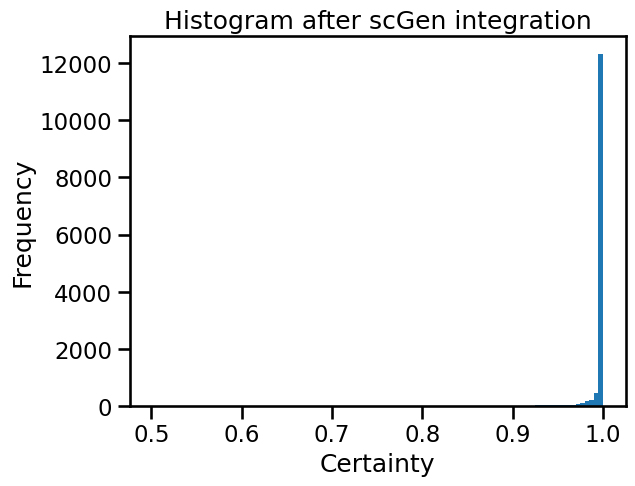

In [41]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scGen integration')
plt.show()

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [42]:
# Evaluating for scanorama_no_blank
accuracy_scGen = accuracy_score(y_test_scGen, y_pred_scGen)
confusion_scGen = confusion_matrix(y_test_scGen, y_pred_scGen)
classification_rep_scGen = classification_report(y_test_scGen, y_pred_scGen)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scGen)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scGen, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scGen)
print("Confusion Matrix:")
print(confusion_scGen)
print("Classification Report:")
print(classification_rep_scGen)

Balanced Accuracy: 0.9541309799612082
Accuracy: 0.9932258984597833
Confusion Matrix:
[[  486    47]
 [   48 13443]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.91      0.91      0.91       533
storm-severe       1.00      1.00      1.00     13491

    accuracy                           0.99     14024
   macro avg       0.95      0.95      0.95     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. 

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [43]:
# Perform 5-fold cross-validation on scGen_no_blank
logistic_classifier = LogisticRegression(solver='liblinear')
cv_scores_scGen = cross_val_score(logistic_classifier, X_train_scGen, y_train_scGen, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scGen)
print("Mean CV Score:", np.mean(cv_scores_scGen))

Cross-Validation Scores: [0.99367201 0.99197789 0.99206703 0.99233443 0.99188876]
Mean CV Score: 0.9923880261696361


## III. Label key: treatment  <a class="anchor" id="treat"></a>

### A. Logistic regression before integration  <a class="anchor" id="treat_sub1"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [15]:
# Perform PCA on `adata` without batch correction or integration
sc.tl.pca(treatment, n_comps=50)  # Choose the desired number of components

# Split adata_no_blank into train and test
X_treatment = treatment.obsm["X_pca"]
y_treatment = treatment.obs['treatment']

X_train_treatment, X_test_treatment, y_train_treatment, y_test_treatment = train_test_split(X_treatment, y_treatment, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the classifier.

In [16]:
# Training
logistic_regression_treatment = LogisticRegression(C=1.0, solver='lbfgs')
logistic_regression_treatment.fit(X_train_treatment, y_train_treatment)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [19]:
# Testing for adata_no_blank
y_pred_treatment = logistic_regression_treatment.predict(X_test_treatment)

# Predict probabilities for test data
probabilities = logistic_regression_treatment.predict_proba(X_test_treatment)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
#uncertainty_measures

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [20]:
# Evaluating for adata_no_blank
accuracy_treatment = accuracy_score(y_test_treatment, y_pred_treatment)
print("Accuracy:", accuracy_treatment)

Accuracy: 0.13043478260869565


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [21]:
# Perform 5-fold cross-validation on adata_no_blank
logistic_regression = LogisticRegression(C=1.0, solver='liblinear')
cv_scores_treatment = cross_val_score(logistic_regression, X_train_treatment, y_train_treatment, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment)
print("Mean CV Score:", np.mean(cv_scores_treatment))

Cross-Validation Scores: [0.13265306 0.14965986 0.17006803 0.18088737 0.10238908]
Mean CV Score: 0.14713148057857955


### B. Logistic regression after integration with harmony  <a class="anchor" id="treat_sub2"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [15]:
# Split into train and test
X_treatment_harmony = treatment_harmony.obsm['X_emb']
y_treatment_harmony = treatment_harmony.obs['treatment']

X_train_treatment_harmony, X_test_treatment_harmony, y_train_treatment_harmony, y_test_treatment_harmony = train_test_split(X_treatment_harmony, y_treatment_harmony, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the classifier.

In [17]:
# Training
logistic_regression_treatment_harmony = LogisticRegression(C=1.0, solver='liblinear')
logistic_regression_treatment_harmony.fit(X_train_treatment_harmony, y_train_treatment_harmony)

LogisticRegression(solver='liblinear')

<b> Step 3: <b>
    
Use the trained classifier to make predictions on the test set.

In [18]:
# Testing 
y_pred_treatment_harmony = logistic_regression_treatment_harmony.predict(X_test_treatment_harmony)

# Predict probabilities for test data
probabilities = logistic_regression_treatment_harmony.predict_proba(X_test_treatment_harmony)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.83474635, 0.07669701, 0.07807707, 0.09217386, 0.08946232,
       0.12596908, 0.53260548, 0.06954459, 0.08801694, 0.12616151,
       0.07126639, 0.06684782, 0.14090569, 0.10094476, 0.48935443,
       0.06971649, 0.08661309, 0.07016798, 0.85150824, 0.0759078 ,
       0.09305844, 0.54113957, 0.09874505, 0.13230486, 0.17822884,
       0.32129616, 0.13649666, 0.06052031, 0.06607767, 0.06021963,
       0.09778251, 0.08662548, 0.15462532, 0.16761621, 0.05927968,
       0.07777517, 0.10456594, 0.09774567, 0.09503315, 0.10726328,
       0.18025537, 0.11704425, 0.09373604, 0.07384529, 0.14189673,
       0.25703622, 0.25523314, 0.24922266, 0.10843699, 0.17711026,
       0.08004964, 0.67965595, 0.16374813, 0.05466189, 0.09878256,
       0.13249105, 0.06013309, 0.21840975, 0.13705676, 0.10073243,
       0.10573741, 0.09323458, 0.79481096, 0.0957547 , 0.10665444,
       0.1634636 , 0.19160752, 0.05977791, 0.0989171 , 0.13306714,
       0.21279391, 0.0677203 , 0.08219123, 0.12834506, 0.07600

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [19]:
# Evaluating for adata_no_blank
accuracy_treatment_harmony = accuracy_score(y_test_treatment_harmony, y_pred_treatment_harmony)
print("Accuracy:", accuracy_treatment_harmony)

Accuracy: 0.11684782608695653


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [20]:
# Perform 5-fold cross-validation
logistic_regression_treatment_harmony = LogisticRegression()
cv_scores_treatment_harmony = cross_val_score(logistic_regression_treatment_harmony, X_train_treatment_harmony, y_train_treatment_harmony, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_harmony)
print("Mean CV Score:", np.mean(cv_scores_treatment_harmony))

Cross-Validation Scores: [0.12585034 0.15986395 0.15986395 0.17064846 0.11262799]
Mean CV Score: 0.1457709363608925


### C. SVM after integration with scanorama  <a class="anchor" id="treat_sub3"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [21]:
# Split into train and test
X_treatment_scanorama = treatment_scanorama.obsm['X_emb']
y_treatment_scanorama = treatment_scanorama.obs['treatment']

X_train_treatment_scanorama, X_test_treatment_scanorama, y_train_treatment_scanorama, y_test_treatment_scanorama = train_test_split(X_treatment_scanorama, y_treatment_scanorama, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [22]:
# Training
logistic_regression_treatment_scanorama = LogisticRegression()
logistic_regression_treatment_scanorama.fit(X_train_treatment_scanorama, y_train_treatment_scanorama)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [23]:
# Testing for adata_no_blank
y_pred_treatment_scanorama = logistic_regression_treatment_scanorama.predict(X_test_treatment_scanorama)

# Predict probabilities for test data
probabilities = logistic_regression_treatment_scanorama.predict_proba(X_test_treatment_scanorama)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.22275261, 0.03661719, 0.04289261, 0.04086566, 0.04136571,
       0.03997097, 0.05504757, 0.04110636, 0.04139863, 0.03975613,
       0.04077312, 0.03701401, 0.04278602, 0.03869826, 0.09978387,
       0.03974074, 0.04064115, 0.04034982, 0.45505938, 0.04314901,
       0.03958056, 0.17788913, 0.04203937, 0.04537023, 0.04009401,
       0.03943925, 0.03805463, 0.04090028, 0.04147506, 0.04290237,
       0.0411198 , 0.04309612, 0.04094867, 0.03961008, 0.04121039,
       0.04073942, 0.0435924 , 0.04157795, 0.04078432, 0.04179657,
       0.03852747, 0.04070021, 0.04616363, 0.03948437, 0.04014742,
       0.06851826, 0.04151962, 0.03922339, 0.03870909, 0.04123046,
       0.04131529, 0.08099737, 0.03927557, 0.0387703 , 0.04295313,
       0.04127793, 0.04222688, 0.0413156 , 0.04478932, 0.03670003,
       0.0394    , 0.03891359, 0.41836487, 0.04138914, 0.04278094,
       0.04141073, 0.04133937, 0.03800881, 0.04314772, 0.04192786,
       0.0405111 , 0.03858344, 0.04408441, 0.03960954, 0.03826

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [24]:
# Evaluating 
accuracy_treatment_scanorama = accuracy_score(y_test_treatment_scanorama, y_pred_treatment_scanorama)
print("Accuracy:", accuracy_treatment_scanorama)

Accuracy: 0.07608695652173914


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [25]:
# Perform 5-fold cross-validation on adata_no_blank
logistic_regression = LogisticRegression()
cv_scores_treatment_scanorama = cross_val_score(logistic_regression, X_train_treatment_scanorama, y_train_treatment_scanorama, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scanorama)
print("Mean CV Score:", np.mean(cv_scores_treatment_scanorama))

Cross-Validation Scores: [0.08843537 0.08843537 0.08843537 0.08191126 0.09215017]
Mean CV Score: 0.08787351117921571


### D. Logistic regression after integration with scVI  <a class="anchor" id="treat_sub4"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [26]:
# Split into train and test
X_treatment_scVI = treatment_scVI.obsm['X_emb']
y_treatment_scVI = treatment_scVI.obs['treatment']

X_train_treatment_scVI, X_test_treatment_scVI, y_train_treatment_scVI, y_test_treatment_scVI = train_test_split(X_treatment_scVI, y_treatment_scVI, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the classifier.

In [27]:
log_reg_classifier_treatment_scVI = LogisticRegression(C=1.0, solver='liblinear')
log_reg_classifier_treatment_scVI.fit(X_train_treatment_scVI, y_train_treatment_scVI)

LogisticRegression(solver='liblinear')

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [29]:
# Testing for scVI_no_blank
y_pred_treatment_scVI = log_reg_classifier_treatment_scVI.predict(X_test_treatment_scVI)

# Predict probabilities for test data
probabilities = log_reg_classifier_treatment_scVI.predict_proba(X_test_treatment_scVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.03593403, 0.038204  , 0.03772479, 0.03787484, 0.03822706,
       0.03837626, 0.171338  , 0.03810781, 0.03821032, 0.03771405,
       0.03801045, 0.03813849, 0.03756061, 0.03773012, 0.1858842 ,
       0.03700214, 0.03807943, 0.03797023, 0.03616647, 0.03771841,
       0.03784993, 0.61705743, 0.03834106, 0.03783675, 0.03736059,
       0.03810892, 0.03771869, 0.03803917, 0.0384909 , 0.03783767,
       0.03767277, 0.03780565, 0.03754077, 0.0378623 , 0.03814825,
       0.03828622, 0.0375665 , 0.03782315, 0.03818151, 0.03793386,
       0.03733544, 0.03806614, 0.03823394, 0.03799253, 0.03824801,
       0.03658604, 0.03759413, 0.03750353, 0.03822824, 0.03796274,
       0.03805345, 0.12024416, 0.03816904, 0.03762082, 0.03825437,
       0.03814867, 0.03820935, 0.03730007, 0.03783285, 0.03670937,
       0.03725669, 0.03821353, 0.03570586, 0.03792588, 0.03808645,
       0.03804378, 0.03874943, 0.038148  , 0.03820701, 0.03822332,
       0.03787976, 0.03793468, 0.03827867, 0.03776274, 0.03804

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [30]:
# Evaluating for scVI_no_blank
accuracy_treatment_scVI = accuracy_score(y_test_treatment_scVI, y_pred_treatment_scVI)
print("Accuracy:", accuracy_treatment_scVI)

Accuracy: 0.051630434782608696


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [31]:
# Perform 5-fold cross-validation on scVI_no_blank
log_reg_classifier = LogisticRegression()
cv_scores_treatment_scVI = cross_val_score(log_reg_classifier, X_train_treatment_scVI, y_train_treatment_scVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scVI)
print("Mean CV Score:", np.mean(cv_scores_treatment_scVI))

Cross-Validation Scores: [0.06462585 0.06802721 0.06122449 0.06143345 0.05802048]
Mean CV Score: 0.06266629518701679


### E. Logistic regression after integration with scANVI  <a class="anchor" id="treat_sub5"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [32]:
# Split into train and test
X_treatment_scANVI = treatment_scANVI.obsm['X_emb']
y_treatment_scANVI = treatment_scANVI.obs['treatment']

X_train_treatment_scANVI, X_test_treatment_scANVI, y_train_treatment_scANVI, y_test_treatment_scANVI = train_test_split(X_treatment_scANVI, y_treatment_scANVI, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the classifier.

In [33]:
# Training
log_reg_classifier_treatment_scANVI = LogisticRegression()
log_reg_classifier_treatment_scANVI.fit(X_train_treatment_scANVI, y_train_treatment_scANVI)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [34]:
# Testing for scANVI_no_blank
y_pred_treatment_scANVI = log_reg_classifier_treatment_scANVI.predict(X_test_treatment_scANVI)

# Predict probabilities for test data
probabilities = log_reg_classifier_treatment_scANVI.predict_proba(X_test_treatment_scANVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.80198223, 0.0290873 , 0.03364609, 0.03214358, 0.04327698,
       0.04782508, 0.10537307, 0.03169586, 0.03460062, 0.03019875,
       0.03540542, 0.03529654, 0.03407747, 0.0487813 , 0.30596205,
       0.03267077, 0.0267022 , 0.03314774, 0.77637404, 0.05111686,
       0.0558746 , 0.82428831, 0.02779834, 0.08043693, 0.04119941,
       0.08136233, 0.03718236, 0.03890299, 0.05675918, 0.06090457,
       0.03692164, 0.0566408 , 0.03773978, 0.03891985, 0.03491009,
       0.03751719, 0.06454114, 0.03465516, 0.03530972, 0.03521682,
       0.04693857, 0.03696346, 0.05422912, 0.04276811, 0.03022181,
       0.13315527, 0.04398931, 0.03105534, 0.0313415 , 0.0303991 ,
       0.04458777, 0.7086718 , 0.02656138, 0.03504922, 0.06135592,
       0.0290618 , 0.08674992, 0.03060191, 0.05006649, 0.05362687,
       0.03435364, 0.03517354, 0.72441202, 0.03180369, 0.05637349,
       0.04241894, 0.03081364, 0.03175943, 0.04046236, 0.02881693,
       0.06527355, 0.02550775, 0.06025888, 0.02698183, 0.04338

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [35]:
# Evaluating for scANVI_no_blank
accuracy_treatment_scANVI = accuracy_score(y_test_treatment_scANVI, y_pred_treatment_scANVI)
print("Accuracy:", accuracy_treatment_scANVI)

Accuracy: 0.10869565217391304


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [36]:
# Perform 5-fold cross-validation on scANVI_no_blank
log_reg_classifier = LogisticRegression()
cv_scores_treatment_scANVI = cross_val_score(log_reg_classifier, X_train_treatment_scANVI, y_train_treatment_scANVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scANVI)
print("Mean CV Score:", np.mean(cv_scores_treatment_scANVI))

Cross-Validation Scores: [0.13605442 0.12244898 0.13265306 0.12627986 0.12286689]
Mean CV Score: 0.12806064405284298


### F. Logistic regression after integration with scGen  <a class="anchor" id="treat_sub6"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [37]:
# Split into train and test
X_treatment_scGen = treatment_scGen.obsm['corrected_latent']
y_treatment_scGen = treatment_scGen.obs['treatment']

X_train_treatment_scGen, X_test_treatment_scGen, y_train_treatment_scGen, y_test_treatment_scGen = train_test_split(X_treatment_scGen, y_treatment_scGen, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the classifier.

In [38]:
# Training
log_reg_classifier_treatment_scGen = LogisticRegression()
log_reg_classifier_treatment_scGen.fit(X_train_treatment_scGen, y_train_treatment_scGen)

LogisticRegression()

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [39]:
# Testing for scGen_no_blank
y_pred_treatment_scGen = log_reg_classifier_treatment_scGen.predict(X_test_treatment_scGen)

# Predict probabilities for test data
probabilities = log_reg_classifier_treatment_scGen.predict_proba(X_test_treatment_scGen)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.99958667, 0.65016326, 0.21796579, 0.48604637, 0.39912124,
       0.14743736, 0.42516067, 0.77447607, 0.35246039, 0.44860326,
       0.27079464, 0.21829705, 0.26004522, 0.21608524, 0.70821685,
       0.70036172, 0.54827871, 0.43794613, 0.9998659 , 0.64008517,
       0.4965472 , 0.99971138, 0.36955581, 0.15108842, 0.34377919,
       0.93678686, 0.30522777, 0.27962388, 0.56403999, 0.41447271,
       0.42403584, 0.173184  , 0.53051275, 0.27639156, 0.17445013,
       0.18600288, 0.73986873, 0.48466812, 0.27291165, 0.40374854,
       0.23360115, 0.33968885, 0.68321253, 0.28818127, 0.87429685,
       0.92802841, 0.15440533, 0.80492672, 0.16252411, 0.72451916,
       0.99995322, 0.99999927, 0.88716631, 0.76720647, 0.44945202,
       0.18187191, 0.13805534, 0.2735048 , 0.7065567 , 0.24844876,
       0.28775315, 0.21074266, 0.99794209, 0.70968572, 0.62364077,
       0.36637525, 0.41775304, 0.4396987 , 0.29326759, 0.66173115,
       0.29470585, 0.26555185, 0.28041218, 0.72542488, 0.23790

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [40]:
# Evaluating for scGen_no_blank
accuracy_treatment_scGen = accuracy_score(y_test_treatment_scGen, y_pred_treatment_scGen)
print("Accuracy:", accuracy_treatment_scGen)

Accuracy: 0.3342391304347826


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [41]:
# Perform 5-fold cross-validation on scGen_no_blank
log_reg_classifier = LogisticRegression(max_iter=1000)
cv_scores_treatment_scGen = cross_val_score(log_reg_classifier, X_train_treatment_scGen, y_train_treatment_scGen, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scGen)
print("Mean CV Score:", np.mean(cv_scores_treatment_scGen))

Cross-Validation Scores: [0.34353741 0.34013605 0.36394558 0.35153584 0.35836177]
Mean CV Score: 0.3515033317081099


## IV. Investigate biology for misclassified instances  <a class="anchor" id="bio"></a>

### A. DrugBank search for misclassified instances  <a class="anchor" id="bio_sub1"></a>

<b> Goal: <b> 
    
* Given the misclassified instances in the SVM classifier which predicts disease_condition, we want to specifically investigate those treatments which have been misclassified as healthy when in fact, they belong to storm-severe and have been treated with some drug. We wish to have a closer look at those misclassified cases to check for any possible patterns in the treatments by referencing the database DrugBank.

1. Before integration: We know we have 71 false negatives which are falsely classified as healthy.

In [49]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask = np.logical_and(y_pred_adata == "healthy", y_test_adata == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices = np.where(misclassified_mask)[0]

# Filter the misclassified data based on the indices
misclassified_data = adata_no_blank[misclassified_indices, :]

# Get the corresponding obs information for the misclassified instances
misclassified_obs = adata_no_blank.obs.iloc[misclassified_indices]

# Create a dataframe with the misclassified obs information
misclassified_df = pd.DataFrame(misclassified_obs)

In [50]:
misclassified_df

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
7,HUVEC-1_10_AA09,HUVEC,HUVEC-1,10,AA09,1,storm-severe,Sulfadoxine,1.00,COC1=NC=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1OC |c:4...,2,0.040062,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,2,0.150240,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,2,0.169010,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,2,0.106021,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,2,0.177290,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12978,HUVEC-1_19_T14,HUVEC,HUVEC-1,19,T14,1,storm-severe,carglumic-acid,0.10,"NC(=O)N[C@@H](CCC(O)=O)C(O)=O |a:4,r|",2,0.185662,NaN
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,2,0.140607,NaN
13717,HUVEC-1_1_F45,HUVEC,HUVEC-1,1,F45,1,storm-severe,Nutlin-3a,0.30,COC1=CC=C(C2=N[C@H]([C@@H](N2C(=O)N2CCNC(=O)C2...,0,0.036424,NaN
13780,HUVEC-1_1_H19,HUVEC,HUVEC-1,1,H19,1,storm-severe,Tozasertib,0.30,CN1CCN(CC1)C1=NC(SC2=CC=C(NC(=O)C3CC3)C=C2)=NC...,4,0.025962,NaN


In [51]:
#unique_treatments = misclassified_df['treatment'].nunique()
#print("Number of unique treatments:", unique_treatments)

duplicate_treatments = misclassified_df['treatment'].value_counts()
duplicate_treatments = duplicate_treatments[duplicate_treatments > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments.index.tolist())

Treatment names appearing more than once:
['Benazepril', 'dexamethasone sodium phosphate']


### B. DrugBank search for misclassified instances  from SVM harmony <a class="anchor" id="bio_sub2"></a>

2. After harmony integration: We know we have 86 false negatives which are falsely classified as healthy.

In [52]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_harmony = np.logical_and(y_pred_harmony == "healthy", y_test_harmony == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_harmony = np.where(misclassified_mask_harmony)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_harmony = harmony_no_blank.obs.iloc[misclassified_indices_harmony]

# Convert the misclassified obs information to a dataframe
misclassified_df_harmony = pd.DataFrame(misclassified_obs_harmony)

In [53]:
misclassified_df_harmony

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,silhouette_temp,cluster,n_cells
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,0.155181,1,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,0.171783,1,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,0.074518,1,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,0.203800,1,NaN
644,HUVEC-1_10_K30,HUVEC,HUVEC-1,10,K30,1,storm-severe,Methylergonovine,0.01,CC[C@@H](CO)NC(=O)[C@H]1CN(C)[C@@H]2CC3=CNC4=C...,0.156274,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,0.096607,1,NaN
13282,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,storm-severe,Indirubin,1.00,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...,0.049543,0,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0.152698,0,NaN
13827,HUVEC-1_1_I23,HUVEC,HUVEC-1,1,I23,1,storm-severe,Benznidazole,2.50,"[O-][N+](=O)C1=NC=CN1CC(=O)NCC1=CC=CC=C1 |c:5,...",0.174258,0,NaN


In [54]:
#unique_treatments_harmony = misclassified_df_harmony['treatment'].nunique()
#print("Number of unique treatments:", unique_treatments_harmony)

duplicate_treatments_harmony = misclassified_df_harmony['treatment'].value_counts()
duplicate_treatments_harmony = duplicate_treatments_harmony[duplicate_treatments_harmony > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_harmony.index.tolist())

Treatment names appearing more than once:
['Benazepril']


Again, we see that Benazepril is more often misclassified, however after harmony integration this is now the only one.

### C. DrugBank search for misclassified instances  from SVM scanorma <a class="anchor" id="bio_sub3"></a>
3. After scanorama integration: We know we have 66 false negatives which are falsely classified as healthy.

In [52]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scanorama = np.logical_and(y_pred_scanorama == "healthy", y_test_scanorama == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scanorama = np.where(misclassified_mask_scanorama)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scanorama = scanorama_no_blank.obs.iloc[misclassified_indices_scanorama]

# Convert the misclassified obs information to a dataframe
misclassified_df_scanorama = pd.DataFrame(misclassified_obs_scanorama)

# Save the dataframe as a CSV file
misclassified_df_scanorama.to_csv('misclassified_scanorama_obs.csv')

misclassified_df_scanorama

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
348,HUVEC-1_1_D45,HUVEC,HUVEC-1,1,D45,1,storm-severe,BIIB021,1.000,COC1=C(C)C=NC(CN2C=NC3=C(Cl)N=C(N)N=C23)=C1C |...,10,0.048549,-0.226690
380,HUVEC-1_1_E31,HUVEC,HUVEC-1,1,E31,1,storm-severe,tosufloxacin,0.010,NC1CCN(C1)C1=C(F)C=C2C(=O)C(=CN(C3=C(F)C=C(F)C...,0,0.118367,1.137625
513,HUVEC-1_1_H32,HUVEC,HUVEC-1,1,H32,1,storm-severe,PD168393,1.000,BrC1=CC(NC2=NC=NC3=CC=C(NC(=O)C=C)C=C23)=CC=C1...,0,0.113317,1.083888
644,HUVEC-1_1_K30,HUVEC,HUVEC-1,1,K30,1,storm-severe,Latanoprost,0.250,CC(C)OC(=O)CCC\C=C/C[C@H]1[C@@H](O)C[C@@H](O)[...,0,0.021998,0.885727
1167,HUVEC-1_1_W15,HUVEC,HUVEC-1,1,W15,1,storm-severe,Nutlin-3a,0.100,COC1=CC=C(C2=N[C@H]([C@@H](N2C(=O)N2CCNC(=O)C2...,0,0.149354,0.814435
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12879,HUVEC-1_18_Q45,HUVEC,HUVEC-1,18,Q45,1,storm-severe,AZD2014,3.000,CNC(=O)C1=CC=CC(=C1)C1=CC=C2C(N=C(N=C2N2CCOC[C...,5,0.015093,-0.348559
12897,HUVEC-1_18_R18,HUVEC,HUVEC-1,18,R18,1,storm-severe,Refametinib,0.300,COC1=C(NS(=O)(=O)C2(C[C@H](O)CO)CC2)C(NC2=CC=C...,0,-0.027442,0.969504
13016,HUVEC-1_18_U03,HUVEC,HUVEC-1,18,U03,1,storm-severe,telotristat,0.025,CC1=NN(C=C1)C1=C(C=CC(Cl)=C1)[C@@H](OC1=NC(N)=...,0,0.155517,0.873162
13581,HUVEC-1_19_C38,HUVEC,HUVEC-1,19,C38,1,storm-severe,enoxolone,1.000,CC1(C)[C@@H](O)CC[C@@]2(C)C1CC[C@]1(C)C2C(=O)C...,2,0.184387,0.798291


In [53]:
unique_treatments_scanorama = misclassified_df_scanorama['treatment'].nunique()
print("Number of unique treatments:", unique_treatments_scanorama)

duplicate_treatments_scanorama = misclassified_df_scanorama['treatment'].value_counts()
duplicate_treatments_scanorama = duplicate_treatments_scanorama[duplicate_treatments_scanorama > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scanorama.index.tolist())

Number of unique treatments: 61
Treatment names appearing more than once:
['Orlistat', 'Ivacaftor', 'Clindamycin palmitate']


In [56]:
if 'Benazepril' in misclassified_df_scanorama['treatment'].unique():
    print("Benazepril is present")
else:
    print("Benazepril is not present")

Benazepril is not present


We note that Benazepril not does not show up as misclassified at all but we find three other treatments misclassifed as healthy more than once.

### D. DrugBank search for misclassified instances  from SVM scVI <a class="anchor" id="bio_sub4"></a>

2. After scVI integration: We know we have 66 false negatives which are falsely classified as healthy.

In [32]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scVI = np.logical_and(y_pred_scVI == "healthy", y_test_scVI == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scVI = np.where(misclassified_mask_scVI)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scVI = scVI_no_blank.obs.iloc[misclassified_indices_scVI]

# Convert the misclassified obs information to a dataframe
misclassified_df_scVI = pd.DataFrame(misclassified_obs_scVI)

# Save the dataframe as a CSV file
misclassified_df_scVI.to_csv('misclassified_scVI_obs.csv')

In [33]:
misclassified_df_scVI

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
7,HUVEC-1_10_AA09,HUVEC,HUVEC-1,10,AA09,1,storm-severe,Sulfadoxine,1.00,COC1=NC=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1OC |c:4...,2,-0.490524,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,2,-0.605416,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,2,-0.589110,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,2,-0.627903,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,2,-0.543637,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,HUVEC-1_19_L44,HUVEC,HUVEC-1,19,L44,1,storm-severe,Niclosamide,0.25,OC1=C(C=C(Cl)C=C1)C(=O)NC1=C(Cl)C=C(C=C1)[N+](...,0,-0.575660,NaN
12978,HUVEC-1_19_T14,HUVEC,HUVEC-1,19,T14,1,storm-severe,carglumic-acid,0.10,"NC(=O)N[C@@H](CCC(O)=O)C(O)=O |a:4,r|",2,-0.630989,NaN
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,2,-0.643587,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0,-0.505596,NaN


In [34]:
#unique_treatments_harmony = misclassified_df_harmony['treatment'].nunique()
#print("Number of unique treatments:", unique_treatments_harmony)

duplicate_treatments_scVI = misclassified_df_scVI['treatment'].value_counts()
duplicate_treatments_scVI = duplicate_treatments_scVI[duplicate_treatments_scVI > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scVI.index.tolist())

Treatment names appearing more than once:
['dexamethasone sodium phosphate', 'Benazepril']


Again, we see that Benazepril is more often misclassified.

### E. DrugBank search for misclassified instances  from SVM scANVI <a class="anchor" id="bio_sub5"></a>
3. After scANVI integration: We know we have 66 false negatives which are falsely classified as healthy.

In [35]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scANVI = np.logical_and(y_pred_scANVI == "healthy", y_test_scANVI == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scANVI = np.where(misclassified_mask_scANVI)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scANVI = scANVI_no_blank.obs.iloc[misclassified_indices_scANVI]

# Convert the misclassified obs information to a dataframe
misclassified_df_scANVI = pd.DataFrame(misclassified_obs_scANVI)

# Save the dataframe as a CSV file
misclassified_df_scANVI.to_csv('misclassified_scANVI_obs.csv')

misclassified_df_scANVI

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
7,HUVEC-1_10_AA09,HUVEC,HUVEC-1,10,AA09,1,storm-severe,Sulfadoxine,1.00,COC1=NC=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1OC |c:4...,2,0.798213,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,2,0.641802,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,2,0.803878,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,2,0.771097,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,2,0.774943,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,HUVEC-1_19_L44,HUVEC,HUVEC-1,19,L44,1,storm-severe,Niclosamide,0.25,OC1=C(C=C(Cl)C=C1)C(=O)NC1=C(Cl)C=C(C=C1)[N+](...,0,0.509678,NaN
12978,HUVEC-1_19_T14,HUVEC,HUVEC-1,19,T14,1,storm-severe,carglumic-acid,0.10,"NC(=O)N[C@@H](CCC(O)=O)C(O)=O |a:4,r|",2,0.807390,NaN
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,2,0.806318,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0,0.764448,NaN


In [37]:
unique_treatments_scANVI = misclassified_df_scANVI['treatment'].nunique()
print("Number of unique treatments:", unique_treatments_scANVI)

duplicate_treatments_scANVI = misclassified_df_scANVI['treatment'].value_counts()
duplicate_treatments_scANVI = duplicate_treatments_scANVI[duplicate_treatments_scANVI > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scANVI.index.tolist())

Number of unique treatments: 63
Treatment names appearing more than once:
['dexamethasone sodium phosphate', 'Benazepril']


We note that Benazepril shows up more than once again.

### F. DrugBank search for misclassified instances  from SVM scGen <a class="anchor" id="bio_sub6"></a>
3. After scGen integration: We know we have 54 false negatives which are falsely classified as healthy.

In [13]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scGen = np.logical_and(y_pred_scGen == "healthy", y_test_scGen == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scGen = np.where(misclassified_mask_scGen)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scGen = scGen_no_blank.obs.iloc[misclassified_indices_scGen]

# Convert the misclassified obs information to a dataframe
misclassified_df_scGen = pd.DataFrame(misclassified_obs_scGen)

# Save the dataframe as a CSV file
misclassified_df_scGen.to_csv('misclassified_scGen_obs.csv')

misclassified_df_scGen

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,_scvi_batch,_scvi_labels,concat_batch,cluster,silhouette_temp,n_cells
192,HUVEC-1_10_AE17,HUVEC,HUVEC-1,10,AE17,1,storm-severe,Flumazenil,1.000,CCOC(=O)C1=C2CN(C)C(=O)C3=CC(F)=CC=C3N2C=N1 |c...,9,2,0,0,-0.002365,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.500,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,9,2,0,0,0.137195,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.010,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,9,2,0,0,0.143524,NaN
554,HUVEC-1_10_I25,HUVEC,HUVEC-1,10,I25,1,storm-severe,mepacrine,0.100,CCN(CC)CCC[C@H](C)NC1=C2C=CC(Cl)=CC2=NC2=CC=C(...,9,2,0,0,0.040307,NaN
1050,HUVEC-1_10_T33,HUVEC,HUVEC-1,10,T33,1,storm-severe,Methotrexate,0.250,CN(CC1=CN=C2N=C(N)N=C(N)C2=N1)C1=CC=C(C=C1)C(=...,9,2,0,0,-0.031495,NaN
1230,HUVEC-1_10_X39,HUVEC,HUVEC-1,10,X39,1,storm-severe,Etofylline clofibrate,0.025,CN1C2=C(N(CCOC(=O)C(C)(C)OC3=CC=C(Cl)C=C3)C=N2...,9,2,0,0,0.022837,NaN
1333,HUVEC-1_11_AA07,HUVEC,HUVEC-1,11,AA07,1,storm-severe,Florfenicol,0.010,CS(=O)(=O)C1=CC=C(C=C1)[C@@H](O)[C@@H](CF)NC(=...,10,2,0,0,0.017051,NaN
1365,HUVEC-1_11_AA40,HUVEC,HUVEC-1,11,AA40,1,storm-severe,Brilliant Green cation,0.025,CCN(CC)C1=CC=C(C=C1)C(C1=CC=CC=C1)=C1C=CC(C=C1...,10,2,0,6,-0.057490,NaN
1746,HUVEC-1_11_F25,HUVEC,HUVEC-1,11,F25,1,storm-severe,Epalrestat,0.010,C\C(\C=C1/SC(=S)N(CC(O)=O)C1=O)=C/C1=CC=CC=C1 ...,10,2,0,0,-0.047485,NaN
1801,HUVEC-1_11_G38,HUVEC,HUVEC-1,11,G38,1,storm-severe,Miglitol,1.000,OCCN1C[C@H](O)[C@H](O)[C@H](O)[C@H]1CO,10,2,0,0,0.077277,NaN


In [14]:
unique_treatments_scGen = misclassified_df_scGen['treatment'].nunique()
print("Number of unique treatments:", unique_treatments_scGen)

duplicate_treatments_scGen = misclassified_df_scGen['treatment'].value_counts()
duplicate_treatments_scGen = duplicate_treatments_scGen[duplicate_treatments_scGen > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scGen.index.tolist())

Number of unique treatments: 51
Treatment names appearing more than once:
['Thymoquinone']


In [15]:
if 'Benazepril' in misclassified_df_scGen['treatment'].unique():
    print("Benazepril is present")
else:
    print("Benazepril is not present")

Benazepril is not present
